# Phase unwrapping

The goal of this notebook is to read an interferogram image (i.e., 2-D array of phase values) and unwrap it. Phase unwrapping is a critical process in interferometry, which involves recovering unambiguous phase data from the interferogram.

A SAR interferogram represents the phase difference between two radar acquisitions (i.e., two SLC images). The phase difference is usually wrapped within a range of 0 to 2π, because phase is inherently cyclical. When the true phase difference exceeds 2π, it gets "wrapped" into this range, creating a discontinuous phase signal. Phase unwrapping refers to the process of reconstructing the continuous phase field from the wrapped phase data.

Unwrapping an interferogram is essential for extracting correctly information contained in the phase such as surface topography and earth surface deformations.

There are many approaches that tried to solve the unwrapping problem, tackling challenging scenarios involving noise or large phase discontinuities. Here we present the Network-flow Algorithm for Phase Unwrapping approach (C. W. Chen and H. A. Zebker, 2000), which is implemented in the SNAPHU package.

## Loading the data
The data is stored on the Jupyterhub server, so we need to load it using their respective paths.
In this Notebook we will use the resulting wrapped interferogram from `Notebook 8`, but we need to process it in the radar geometry in order to unwrap it (while in the `Notebook 8` we end the whole process by doing a geometric orthorectification, just for better visualization puproses)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
from pathlib import Path
import cmcrameri as cmc
import snaphu
import seaborn as sns
from IPython.display import clear_output

In [2]:
# Define Path to the data
root = Path('~/shared/datasets/rs/datapool/mrs').expanduser()
src_path = root / 's1-interferogram/08_complex_unwrapping/handout'


def _preprocess(X):
    name = X.encoding['source'].split('_')[-1].removesuffix('.tif')
    X = X.rename({'band_data': name})
    return X


ds = xr.open_mfdataset(
    src_path.glob('*.tif'),
    engine="rasterio",
    preprocess=_preprocess,
    parallel=True
    ).squeeze()

/home/npikall/miniconda3/envs/07_amplitude-and-phase/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored


In [3]:
# Set cyclic and linear colormaps
cmap_cyc = sns.color_palette("hls", as_cmap=True)  # "cmc.romaO"
cmap_lin = 'cmc.roma_r'
cmap_disp = "cmc.vik"

# Create a mask for the areas which have no data
mask = (ds.phase
        .where(ds.phase == 0, True, False)
        .astype(bool))

Lets start by displaying the phase image, which will be unwrapped.

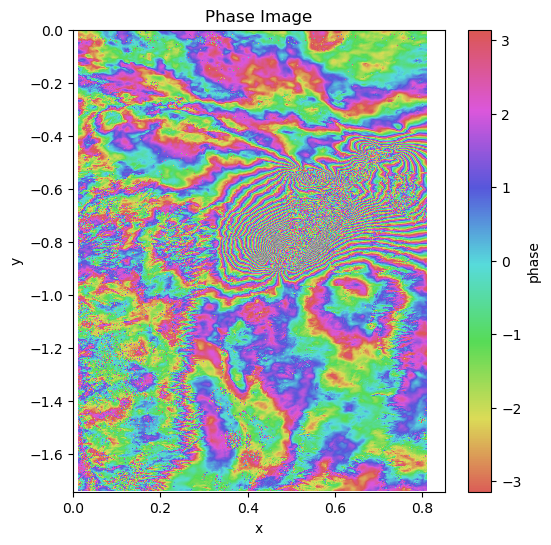

In [4]:
# Plot Phase Image
fig, axs = plt.subplots(figsize=(6, 6))

(ds.phase.where(mask)
 .plot.imshow(cmap=cmap_cyc, zorder=1)
 .axes.set_title("Phase Image"))
plt.show()

## Unwrapping

As we will be doing the unwrapping multiple times in this notebook lets create a function that does the unwrapping for us on `xarray DataArray` objects.
The actual core function where the unwrapping is happening is `snaphu.unwrap_phase` from the `snaphu` package. This function needs a 2D numpy array as input, where each pixel value is a complex number.
Therefore we have to convert the `xarray DataArray` to a 2D numpy array with complex values. We do that by combining the phase and intensity bands to a complex array.
The actual unwrapping is essentially an addition of the phase values, such that the values are continuous and not between $-\pi$ and $\pi$.

![](https://forum.step.esa.int/uploads/default/original/3X/5/d/5d9d18e2a3121a4bb80cb93a8f62aed742e35fc2.png)

*Figure 1: Illustration of how the unwrapping of the phase works. (Source: ESA)*.

In [5]:
def unwrap_array(data: xr.DataArray,
                 complex_var: str = 'cmplx',
                 ouput_var: str = 'unwrapped',
                 mask: xr.DataArray = True,
                 coherence: xr.DataArray = None,
                 mask_nodata_value: int = 0,
                 coh_low_threshold: float = None,
                 coh_high_threshold: float = None,
                 nlooks=1.0, cost="smooth", init="mcf",
                 **kwargs) -> xr.DataArray:
    """
    Unwraps the phase data using the snaphu algorithm.

    :param data: xarray DataArray with complex numbers
    :param complex_var: Name of the variable with the complex numbers
    :param ouput_var: Name of the variable with the unwrapped phase
    :param mask: xarray DataArray with mask values
    :param coherence: xarray DataArray with coherence values (optional)
    :param mask_nodata_value: Value of the no data pixels in the mask
    :param coh_low_threshold: Lower threshold for the coherence values
    :param coh_high_threshold: Higher threshold for the coherence values

    :return: xarray DataArray with the unwrapped phase
    """
    # Get the complex data
    data_arr = data[complex_var]

    # Create a mask for areas with no data
    if mask is True:
        mask = (data_arr.real != mask_nodata_value).astype(bool)

    # Apply coherence thresholds if provided
    if coherence is not None:
        if coh_low_threshold is not None:
            coh_mask = (coherence >= coh_low_threshold).astype(bool)
            mask = mask & coh_mask
        if coh_high_threshold is not None:
            coh_mask = (coherence <= coh_high_threshold).astype(bool)
            mask = mask & coh_mask

    # Apply the mask to the data
    data_arr = data_arr.where(mask)

    if coherence is None:
        coherence = np.ones_like(data_arr.real)

    # Unwrap the phase (already in complex form)
    unw, _ = snaphu.unwrap(data_arr,
                           coherence, nlooks=nlooks,
                           cost=cost, init=init,
                           mask=mask, **kwargs)

    # Clear the output to avoid printing the snaphu output
    clear_output()

    # Build xarray DataArray with the unwrapped phase
    # unw_da = xr.DataArray(unw, coords=data.coords, dims=data.dims)
    # data = data.to_dataset()
    data[ouput_var] = (('y', 'x'), unw)

    # Mask the unwrapped phase
    # unw_da = unw_da.where(mask)
    data[ouput_var] = data[ouput_var].where(mask)
    return data

### Unwrapping on a Subset

As the original image is too large to unwrap in a reasonable time, we will unwrap a subset of the image. In this case we will unwrap an area of 500x500 pixels.

In [ ]:
# Select a subset of the data
dx, dy = 500, 500
x0, y0 = 2800, 1700


def subsetting(ds, x0: int = 0,
               y0: int = 0,
               dx: int = 500,
               dy: int = 500):
    return ds.isel(x=slice(x0, x0 + dx), y=slice(y0, y0 + dy))


# Subsetting the data arrays
subset = subsetting(ds.where(mask), x0, y0, dx, dy)

# Unwrap the subset
subset = unwrap_array(subset,
                      complex_var='cmplx',
                      ouput_var='unwrapped')

Now lets compare the wrapped and unwrapped phase images, to see what has happend.

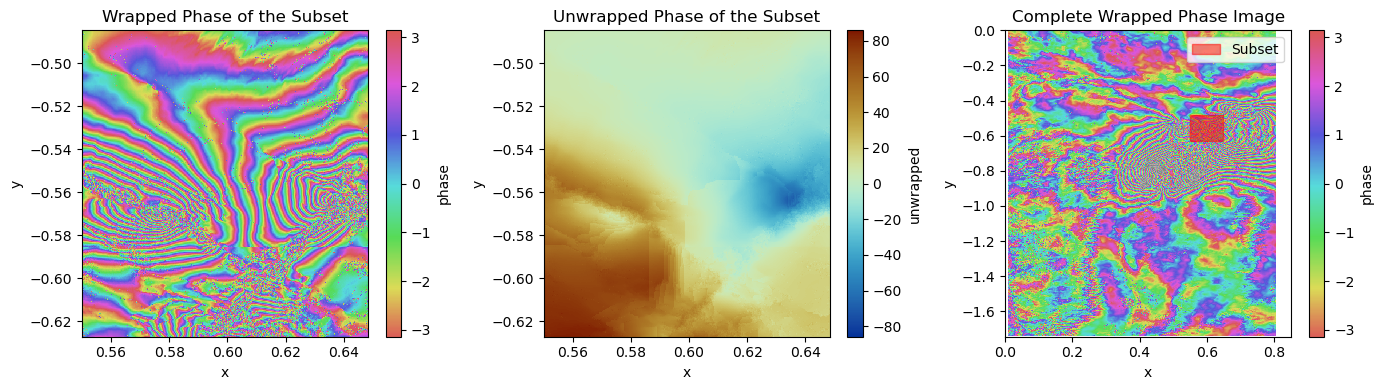

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Wrapped Phase

(subset.phase
 .plot.imshow(cmap=cmap_cyc, ax=axs[0])
 .axes.set_title("Wrapped Phase of the Subset"))

# Unwrapped Phase
(subset.unwrapped.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Unwrapped Phase of the Subset"))

# Subset inside the complete image
(ds.phase.where(mask)
 .plot.imshow(cmap=cmap_cyc, zorder=1, ax=axs[2])
 .axes.set_title("Complete Wrapped Phase Image"))

x_start = ds.phase.coords['x'][x0].item()
y_start = ds.phase.coords['y'][y0].item()
x_end = ds.phase.coords['x'][x0 + dx].item()
y_end = ds.phase.coords['y'][y0 + dy].item()

rect = patches.Rectangle((x_start, y_start),
                         x_end-x_start, y_end-y_start,
                         linewidth=1, edgecolor='r',
                         facecolor='red', alpha=0.5,
                         label='Subset')

# Add the rectangle to the plot
axs[2].add_patch(rect)
axs[2].legend()
plt.tight_layout()

### Unwrapping with coherence mask
Additionally can we try to calculate the unwrapped image, where we are excluding pixels, where the coherence values are lower than a certain threshold. This is done by masking the coherence image with the threshold value and then unwrapping the phase image with the masked coherence image.

In [9]:
threshold1 = 0.3
subset = unwrap_array(subset,
                      coherence=subset.coh,
                      coh_low_threshold=threshold1,
                      complex_var='cmplx',
                      ouput_var='unwrapped_coh')

Lets compare the unwrapped image with and without the coherence mask.

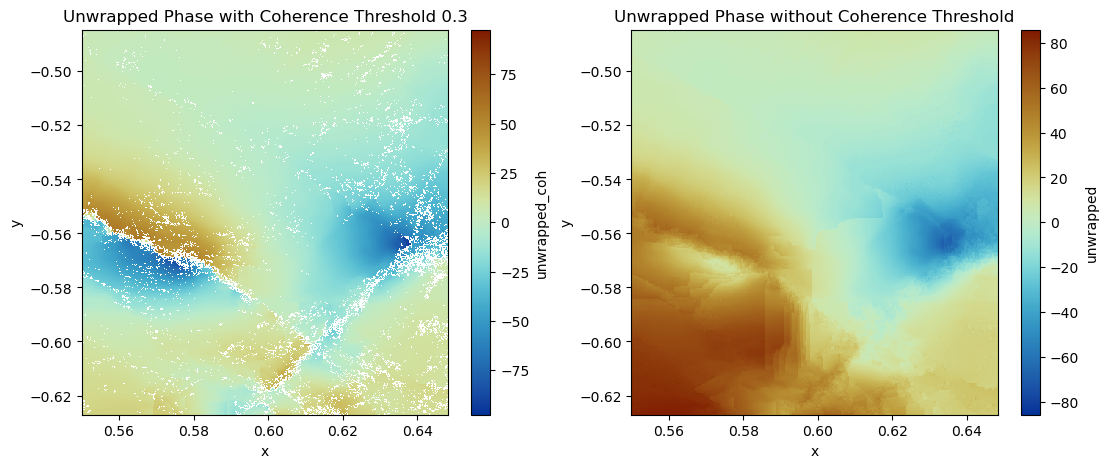

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
(subset.unwrapped_coh.plot.imshow(cmap=cmap_lin, ax=axs[0])
 .axes.set_title(f"Unwrapped Phase with Coherence Threshold {threshold1}"))

(subset.unwrapped.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Unwrapped Phase without Coherence Threshold"))

plt.show()

Lets see if another threshold value for the coherence mask gives better results.

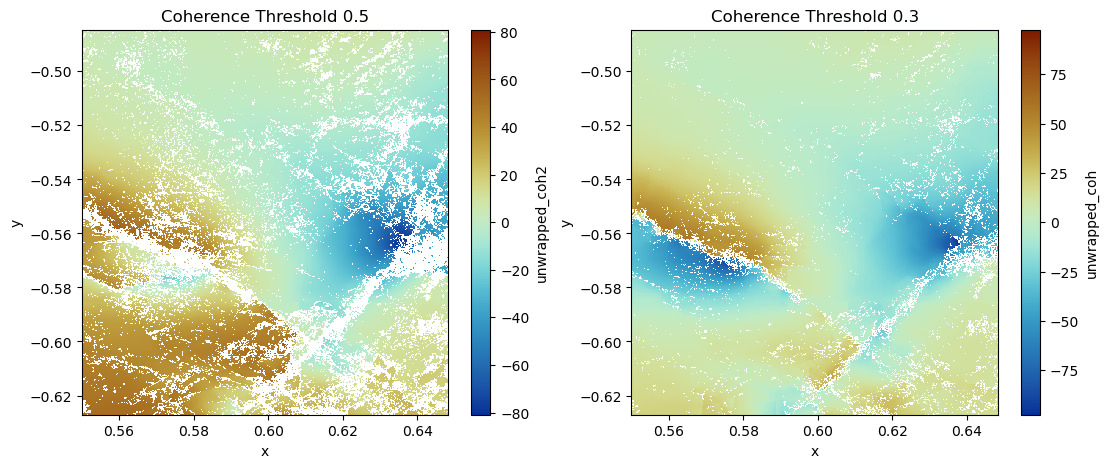

In [11]:
threshold2 = 0.5
subset = unwrap_array(subset,
                      coherence=subset.coh,
                      coh_low_threshold=threshold2,
                      complex_var='cmplx',
                      ouput_var='unwrapped_coh2')

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
(subset.unwrapped_coh2.plot.imshow(cmap=cmap_lin, ax=axs[0])
 .axes.set_title("Coherence Threshold 0.5"))

(subset.unwrapped_coh.plot.imshow(cmap=cmap_lin, ax=axs[1])
 .axes.set_title("Coherence Threshold 0.3"))
plt.show()

## Applying equation for displacement map

From the unwrapped phase image we can calculate the displacement map using the following equation:

$
d = - \frac{\lambda}{4 \cdot \pi} \cdot \Delta \phi_d
$

where:
- $\lambda = 0.056$ for Sentinel-1
- $\Delta \phi_d$ is the unwrapped image

This operation can be very useful for monitoring ground deformation.

In [12]:
def displacement(unw, lambda_val: float = 0.056) -> xr.DataArray:
    """
    Calculates the displacement from the unwrapped phase

    :param unw: xarray DataArray with the unwrapped phase
    :type unw: xr.DataArray
    :param lambda_val: Wavelength of the radar signal
    :type lambda_val: float

    :return: xarray DataArray with the displacement
    :rtype: xr.DataArray
    """
    disp = unw * - lambda_val / (4 * np.pi)
    return disp


# Calculate the displacement
disp_subset = displacement(subset.unwrapped_coh)

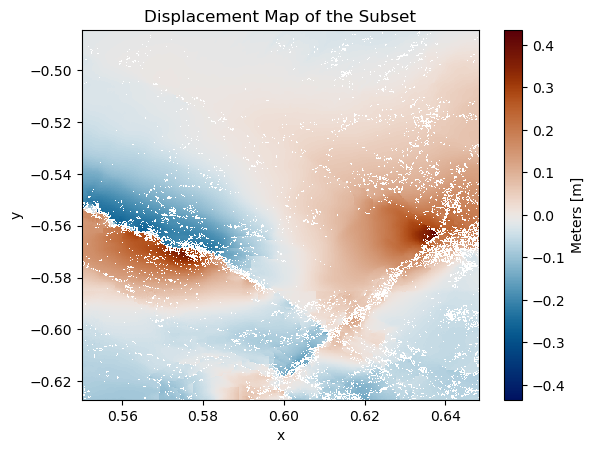

In [22]:
# Plot the displacement map
(disp_subset.plot.imshow(cmap=cmap_disp,
                         cbar_kwargs= {'label': 'Meters [m]'})
 .axes.set_title("Displacement Map of the Subset"))
plt.show()

## Coarsen approach

As the whole data is too large and the processing time is already exceeds 20 minutes when useing a image with 4000x4000 pixels, we can coarsen the image.

In [14]:
kernel_size = 3
lowres = ds.coarsen(x=kernel_size,
                    y=kernel_size,
                    boundary="trim").median()

In [15]:
lowres = unwrap_array(lowres, ntiles=(20, 30),
                      tile_overlap=10,
                      coherence=lowres.coh,
                      coh_low_threshold=0.3,
                      complex_var='cmplx',
                      ouput_var='unwrapped')

We can now plot the unwrapped image of the low resolution image.

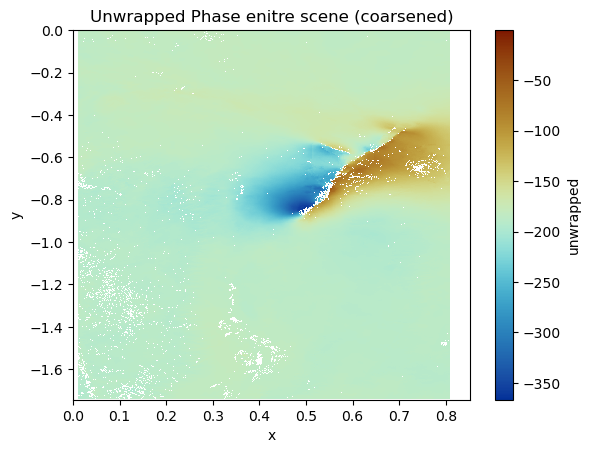

In [16]:
# Plot the unwrapped phase
(lowres.unwrapped.plot.imshow(cmap=cmap_lin)
 .axes.set_title("Unwrapped Phase enitre scene (coarsened)"))
plt.show()

We can also now calculate the displacement map and compare them.

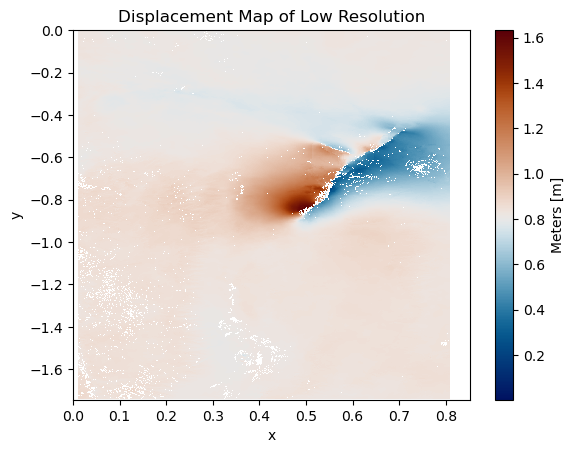

In [23]:
lowres_disp = displacement(lowres.unwrapped)

# Plot the displacement map
(lowres_disp.plot.imshow(cmap=cmap_disp,
                         cbar_kwargs= {'label': 'Meters [m]'})
 .axes.set_title("Displacement Map of Low Resolution"))
plt.show()

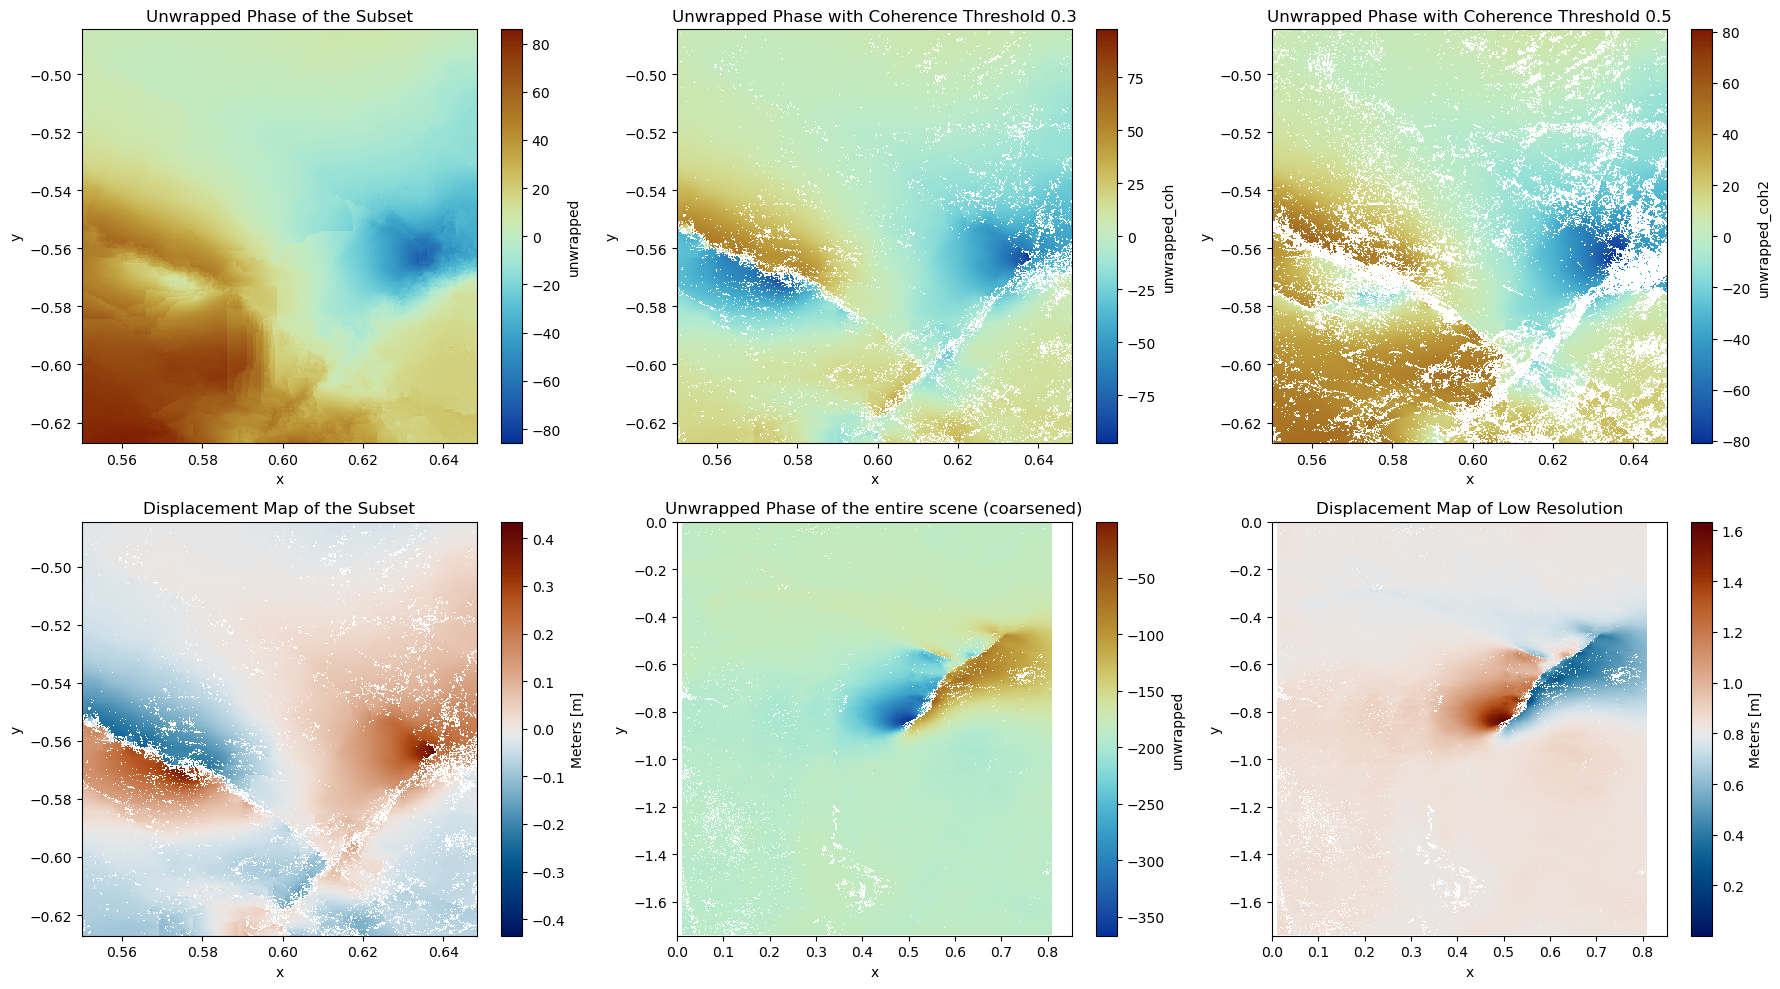

In [24]:
# Plot summary of all previous plots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
ax = axs.ravel()

(subset.unwrapped.plot.imshow(cmap=cmap_lin, ax=ax[0])
 .axes.set_title("Unwrapped Phase of the Subset"))

(subset.unwrapped_coh.plot.imshow(cmap=cmap_lin, ax=ax[1])
 .axes.set_title("Unwrapped Phase with Coherence Threshold 0.3"))

(subset.unwrapped_coh2.plot.imshow(cmap=cmap_lin, ax=ax[2])
 .axes.set_title("Unwrapped Phase with Coherence Threshold 0.5"))

(disp_subset.plot.imshow(cmap=cmap_disp, ax=ax[3],
                         cbar_kwargs= {'label': 'Meters [m]'})
 .axes.set_title("Displacement Map of the Subset"))

(lowres.unwrapped.plot.imshow(cmap=cmap_lin, ax=ax[4])
 .axes.set_title("Unwrapped Phase of the entire scene (coarsened)"))

(lowres_disp.plot.imshow(cmap=cmap_disp, ax=ax[5],
                         cbar_kwargs= {'label': 'Meters [m]'})
 .axes.set_title("Displacement Map of Low Resolution"))

plt.tight_layout()